<a href="https://colab.research.google.com/github/applejxd/colaboratory/blob/master/algorithm/linalg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 線形方程式の求解

### 直接法  

#### LU分解

LU分解はガウスの消去法をするだけ。前進消去・部分ピボット選択・後退代入の過程を行列$L, U, P$にまとめる。

逆行列もLU分解から求まる。$AA^{-1}=I$なので$A\vec{x}_i=\vec{e}_i$を解けばいい。これは他の手法でも同じ。

#### コレスキー分解法

解くべき連立一次方程式$A\vec{x}=\vec{b}$の係数行列$A$が非負定値ならコレスキー分解が可能なので、これを利用。

不定値なら$(A^TA)\vec{x}=A^T\vec{b}$を解く。$A^TA$は必ず対称で非負定値(特異値分解の部分を参照)。

### 間接法

間接法は反復更新で解に収束させることで解く。

共役勾配法なら2次形式の最適化問題に変形して適用。

## 特異値分解

In [133]:
%reset -f

### 右特異ベクトル

行列 $A$ に対して行列 $A^TA$ を考える。
明らかに $(A^TA)^T=A^TA$ なので対称行列。
[スペクトル定理](https://ja.wikipedia.org/wiki/%E3%82%B9%E3%83%9A%E3%82%AF%E3%83%88%E3%83%AB%E5%AE%9A%E7%90%86)より固有値は常に実数である。

また行列 $A$ の非負定値の条件は任意の $\vec{x}\neq\vec{0}$ に対して $\vec{x}^TA\vec{x}\geq0$。
よって任意の $A, \vec{x}\neq\vec{0}$ に対して $\vec{x}^T(A^TA)\vec{x}=||A\vec{x}||^2\geq0$。
これより固有値は常に非負である。そのため固有値の平方根も常に実数である。

これは $AA^T$ でも同様に成立。

実際に確かめるために乱数生成の行列でこれを計算。

<Axes: >

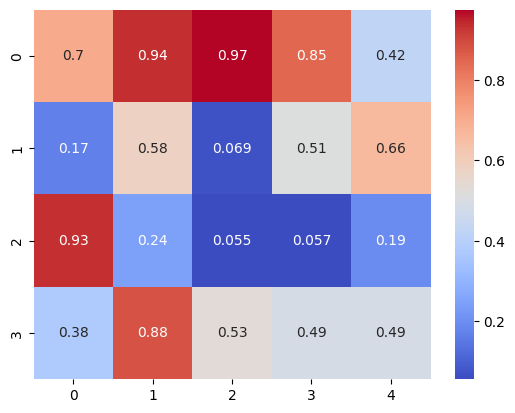

In [134]:
import numpy as np
import seaborn as sns

# 表示の精度を設定
np.set_printoptions(precision=3, suppress=False)

N, M = 4, 5
A = np.random.rand(N, M)
sns.heatmap(A, annot=True, cmap='coolwarm')

$A^TA$ は対称行列

<Axes: >

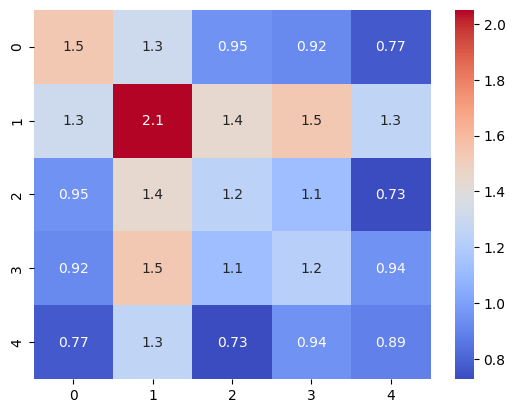

In [135]:
ATA = A.T @ A
sns.heatmap(ATA, annot=True, cmap='coolwarm')

固有値はすべて実数で非負（数値誤差に注意）

w_right=array([ 5.950e+00,  6.240e-01,  3.300e-01,  3.735e-02, -4.492e-16])


<Axes: >

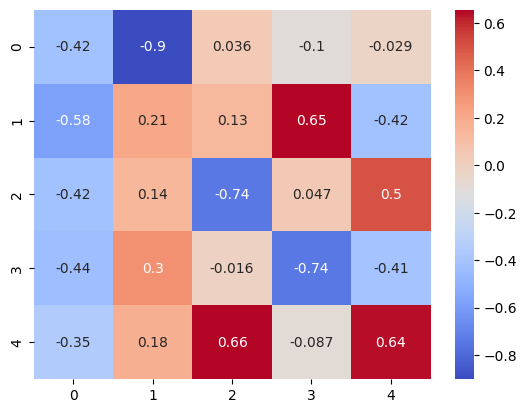

In [136]:
import numpy.linalg as la

w_right, V = la.eigh(ATA)
# 固有値が大きい順
w_right, V = w_right[::-1], V[:, ::-1]
print(f"{w_right=}")
sns.heatmap(V, annot=True, cmap='coolwarm')

固有ベクトルは$V$の各列が対応。
検算で $\vec{v}^T(A^TA)\vec{v}-w$ を計算。

<Axes: >

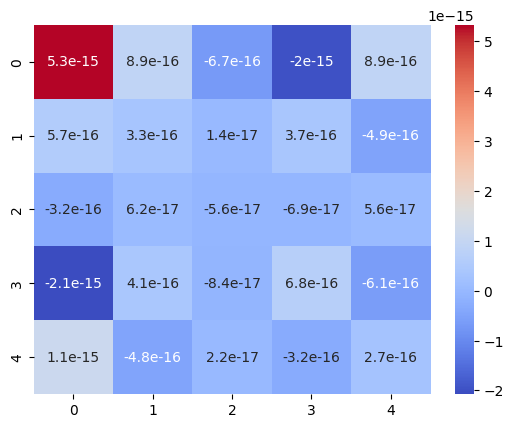

In [137]:
residuals = V.T @ ATA @ V - np.diag(w_right)
sns.heatmap(residuals, annot=True, cmap='coolwarm')

$V$ 行列は直交行列(ユニタリー行列)で[右特異ベクトル](https://manabitimes.jp/math/1280#5)

<Axes: >

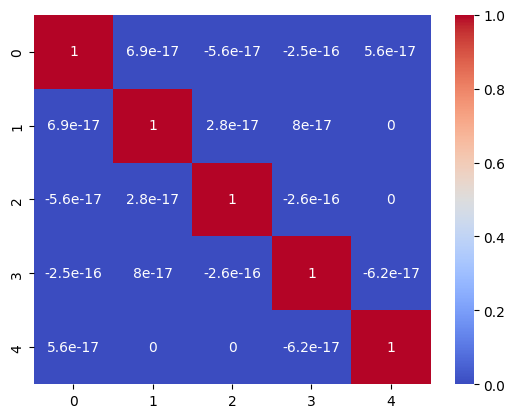

In [138]:
import seaborn as sns

# 検算。ユニタリなら単位行列に近くなる。
sns.heatmap(V.T @ V, annot=True, cmap='coolwarm')

### 左特異ベクトル

同様に $AA^T$ について計算し左特異ベクトル$U$を求める

w_left=array([5.95 , 0.624, 0.33 , 0.037])


<Axes: >

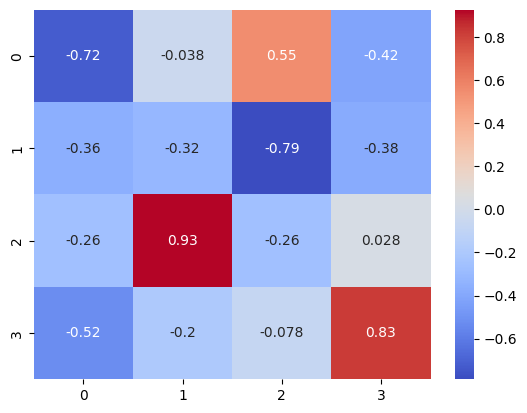

In [139]:
AAT = A @ A.T
w_left, U = la.eigh(AAT)
# 固有値が大きい順
w_left, U = w_left[::-1], U[:, ::-1]

print(f"{w_left=}")
sns.heatmap(U, annot=True, cmap='coolwarm')

左特異ベクトルを検算

<Axes: >

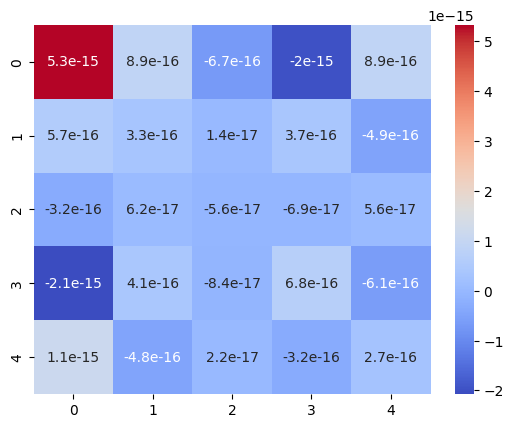

In [140]:
residuals = V.T @ ATA @ V - np.diag(w_right)
sns.heatmap(residuals, annot=True, cmap='coolwarm')

<Axes: >

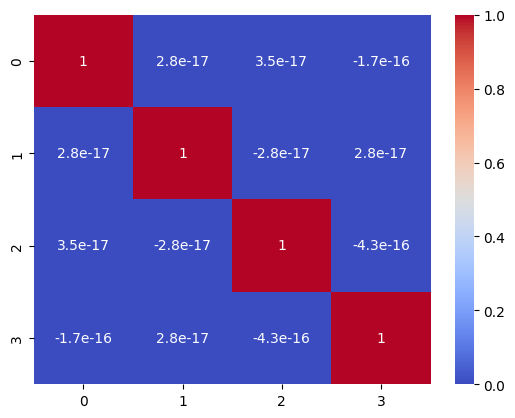

In [141]:
sns.heatmap(U.T @ U, annot=True, cmap='coolwarm')

### 特異値分解

数値誤差の対策。ほぼ0は0とする。

In [142]:
w_right = np.array([w if abs(w) > 1e-10 else 0 for w in w_right])
w_left = np.array([w if abs(w) > 1e-10 else 0 for w in w_left])
print(f"{w_right=}")
print(f"{w_left=}")

w_right=array([5.95 , 0.624, 0.33 , 0.037, 0.   ])
w_left=array([5.95 , 0.624, 0.33 , 0.037])


$A^TA, AA^T$ の固有値の平方根は特異値

In [143]:
sigma_right = np.sqrt(w_right)
sigma_left = np.sqrt(w_left)
print(f"{sigma_right=}")
print(f"{sigma_left=}")

sigma_right=array([2.439, 0.79 , 0.574, 0.193, 0.   ])
sigma_left=array([2.439, 0.79 , 0.574, 0.193])


特異値による行列 $\Sigma$ を作成

In [144]:
Sigma = np.zeros_like(A)
sigma = sigma_right if len(sigma_right) < len(sigma_left) else sigma_left
Sigma[:len(sigma), :len(sigma)] = np.diag(sigma)
print(f"{Sigma=}")

Sigma=array([[2.439, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.79 , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.574, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.193, 0.   ]])


固有ベクトルには符号の不定性があるためそのままでは$A=U\Sigma V^T$を満たすとは限らない。

$\Sigma$の成分は非負なので$(AV)_i=\lambda_iU_i, \lambda_i\geq0$。
そこでこの[条件を満たすように符号の反転をする](
https://math.stackexchange.com/questions/4844816/discrepancies-in-custom-svd-implementation-compared-to-np-linalg-svd-sign-issu)。

<Axes: >

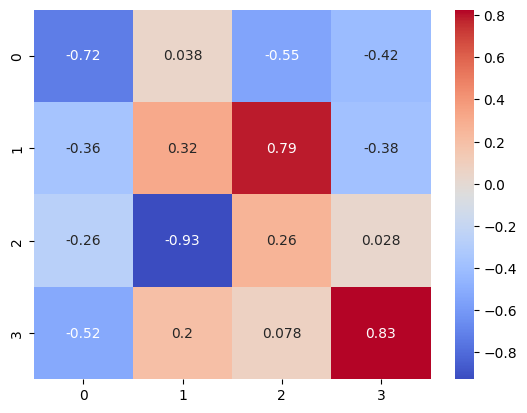

In [145]:
U = np.array([np.sign(np.dot(A @ V[:, idx], U[:, idx])) * U[:, idx]
    for idx in range(U.shape[1])]).T
sns.heatmap(U, annot=True, cmap='coolwarm')

[特異値分解](https://manabitimes.jp/math/1280#5) $A=U\Sigma V^T$ の検算。

<Axes: >

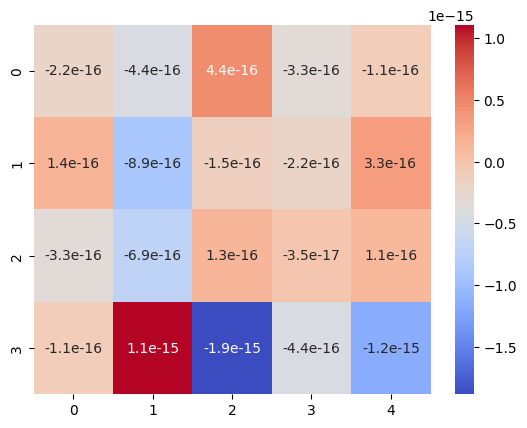

In [146]:
residuals = A - (U @ Sigma @ V.T)
sns.heatmap(residuals, annot=True, cmap='coolwarm')

numpy の標準機能でも特異値分解。

In [147]:
U2, sigma2, V2h = la.svd(A)
print(sigma2)

[2.439 0.79  0.574 0.193]


特異ベクトルは符号の不定性があるため、対角化から求めた結果と一致するとは限らない。

sigma2-sigma=array([-4.441e-16, -2.220e-16,  3.331e-16,  8.604e-16])


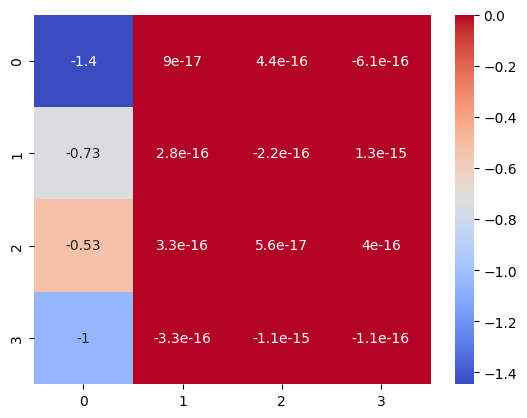

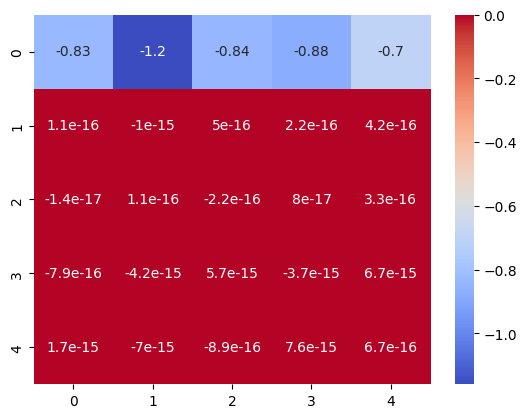

In [148]:
import matplotlib.pyplot as plt

print(f"{sigma2-sigma=}")
sns.heatmap(U-U2, annot=True, cmap='coolwarm')
plt.show()
sns.heatmap(V.T - V2h, annot=True, cmap='coolwarm')
plt.show()

特異分解$A=U\Sigma V^T$はきちんと満たす。

<Axes: >

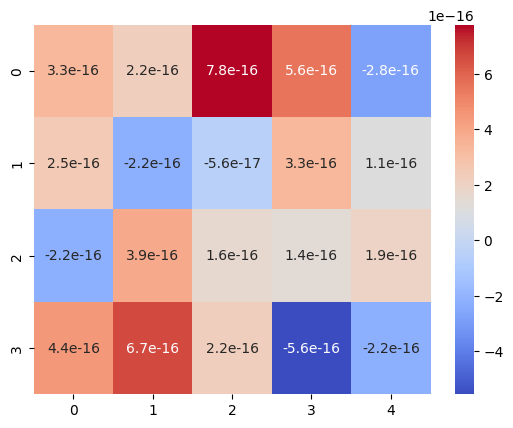

In [149]:
Sigma2 = np.zeros_like(A)
sigma2 = sigma_right if len(sigma_right) < len(sigma_left) else sigma_left
Sigma2[:len(sigma2), :len(sigma2)] = np.diag(sigma2)
residuals = A - (U2 @ Sigma2 @ V2h)
sns.heatmap(residuals, annot=True, cmap='coolwarm')